In [1]:
import pandas as pd
import os
import boto3
import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(os.path.exists('20130502.sequence.index'))
if not os.path.exists('20130502.sequence.index'):
    s3 = boto3.client('s3')
    s3.download_file('1000genomes', 'sequence_indices/20130502.sequence.index', '20130502.sequence.index')
print(os.path.exists('20130502.sequence.index'))

True
True


In [3]:
df = pd.read_csv('20130502.sequence.index',sep='\t')
print(df.columns)
print(df.shape)

Index(['FASTQ_FILE', 'MD5', 'RUN_ID', 'STUDY_ID', 'STUDY_NAME', 'CENTER_NAME',
       'SUBMISSION_ID', 'SUBMISSION_DATE', 'SAMPLE_ID', 'SAMPLE_NAME',
       'POPULATION', 'EXPERIMENT_ID', 'INSTRUMENT_PLATFORM',
       'INSTRUMENT_MODEL', 'LIBRARY_NAME', 'RUN_NAME', 'RUN_BLOCK_NAME',
       'INSERT_SIZE', 'LIBRARY_LAYOUT', 'PAIRED_FASTQ', 'WITHDRAWN',
       'WITHDRAWN_DATE', 'COMMENT', 'READ_COUNT', 'BASE_COUNT',
       'ANALYSIS_GROUP'],
      dtype='object')
(187720, 26)


/Users/michael/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (7,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# subset the df to include only those with Illumina paired end reads
sub = df[df['INSTRUMENT_PLATFORM'] == 'ILLUMINA']
sub = sub[sub['LIBRARY_LAYOUT'] == 'PAIRED']
print(sub.shape)

(170831, 26)


In [5]:
# how many centers are there?
print(sub['CENTER_NAME'].unique())

['BGI' 'SC' 'ILLUMINA' 'MPIMG' 'mpimg' 'BI' 'WUGSC' 'BCM' 'Illumina']


In [6]:
# how many samples are in each center
for c in sub['CENTER_NAME'].unique():
    print(c)
    subsub = sub[sub['CENTER_NAME'] == c]
    print('\t',subsub.shape[0])
    print('\t',len(subsub['SAMPLE_NAME'].unique()))
    print()

BGI
	 10098
	 898

SC
	 34038
	 780

ILLUMINA
	 888
	 109

MPIMG
	 1459
	 98

mpimg
	 42
	 4

BI
	 114641
	 943

WUGSC
	 7033
	 509

BCM
	 2620
	 463

Illumina
	 12
	 3



In [7]:
# Was each sample sequenced at only one facility?
print('Total number of unique samples',len(sub['SAMPLE_NAME'].unique()))
sample_center_counts = { x:0 for x in sub['SAMPLE_NAME'].unique()}
for c in sub['CENTER_NAME'].unique():
    subsub = sub[sub['CENTER_NAME'] == c]
    for s in subsub['SAMPLE_NAME'].unique():
        sample_center_counts[s] += 1

g8er_1 = []
one_count = 0
for x in sample_center_counts.keys():
    if sample_center_counts[x] > 1:
        g8er_1.append(x)
    elif sample_center_counts[x] == 1:
        one_count += 1
    else:
        print('Oops?')
print('Number of samples in multiple centers',len(g8er_1))
print('Number of samples in one center',one_count)

Total number of unique samples 2777
Number of samples in multiple centers 1005
Number of samples in one center 1772


get and load sample information
sample info is downloaded from here 

`aws s3 cp s3://1000genomes/technical/working/20130606_sample_info/20130606_sample_info.xlsx ./`

But it is a xlsx files so I manually pulled out the page I cared about and saved it as

`1000genomes_sample_demographic_info.tsv`


In [8]:
dem_df = pd.read_csv('1000genomes_sample_demographic_info.tsv', sep='\t')
print(dem_df.shape)
print(dem_df.columns)

(3500, 5)
Index(['Sample', 'Family ID', 'Population', 'Population Description',
       'Gender'],
      dtype='object')


In [9]:
# merge demographic information with center information
# create mapping of sample to center
sample_2_center = {x:[] for x in sub['SAMPLE_NAME'].unique()}
for c in sub['CENTER_NAME'].unique():
    subsub = sub[sub['CENTER_NAME'] == c]
    for s in subsub['SAMPLE_NAME'].unique():
        sample_2_center[s].append(c)
dem_df['centers'] = [ str(sample_2_center[s]) if s in sample_2_center else '' for s in dem_df['Sample']]

# how many samples don't have a center
print(dem_df)
print('samples without center',sum(dem_df['centers'] == ''))
print('samples with center',sum(dem_df['centers'] != ''))

       Sample Family ID Population           Population Description  Gender  \
0     HG00096   HG00096        GBR  British in England and Scotland    male   
1     HG00097   HG00097        GBR  British in England and Scotland  female   
2     HG00098   HG00098        GBR  British in England and Scotland    male   
3     HG00099   HG00099        GBR  British in England and Scotland  female   
4     HG00100   HG00100        GBR  British in England and Scotland  female   
...       ...       ...        ...                              ...     ...   
3495  NA21137   NA21137        GIH    Gujarati Indian in Houston,TX  female   
3496  NA21141   NA21141        GIH    Gujarati Indian in Houston,TX  female   
3497  NA21142   NA21142        GIH    Gujarati Indian in Houston,TX  female   
3498  NA21143   NA21143        GIH    Gujarati Indian in Houston,TX  female   
3499  NA21144   NA21144        GIH    Gujarati Indian in Houston,TX  female   

                 centers  
0              ['WUGSC']

In [10]:
def clear_ax(ax, top=False, bottom=False, left=False, right=False):
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    # ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
    ax.yaxis.set_tick_params(width=0.0, labelsize=8)
    ax.xaxis.set_tick_params(width=0.0, labelsize=8)

In [11]:
print(dem_df['Population'])
labels = list(dem_df['Population Description'])
print(len(labels))
print(len(set(labels)))

0       GBR
1       GBR
2       GBR
3       GBR
4       GBR
       ... 
3495    GIH
3496    GIH
3497    GIH
3498    GIH
3499    GIH
Name: Population, Length: 3500, dtype: object
3500
26


In [16]:
# I found useful information about this from this paper
# https://www.nature.com/articles/s41598-021-93878-2#MOESM1
# https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-021-93878-2/MediaObjects/41598_2021_93878_MOESM1_ESM.pdf
print(dem_df.columns)
for center in sub['CENTER_NAME'].unique():
    subsub = dem_df[dem_df['centers'].str.contains(center)]
    print(center,subsub.shape)

Index(['Sample', 'Family ID', 'Population', 'Population Description', 'Gender',
       'centers'],
      dtype='object')
BGI (898, 6)
SC (1182, 6)
ILLUMINA (109, 6)
MPIMG (98, 6)
mpimg (4, 6)
BI (875, 6)
WUGSC (509, 6)
BCM (463, 6)
Illumina (3, 6)


(455, 6)
(420, 6)


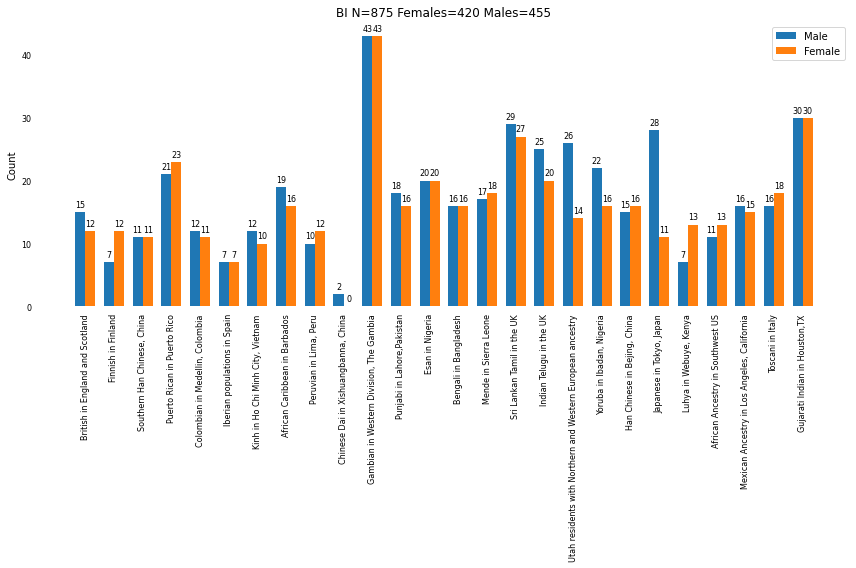

(251, 6)
(258, 6)


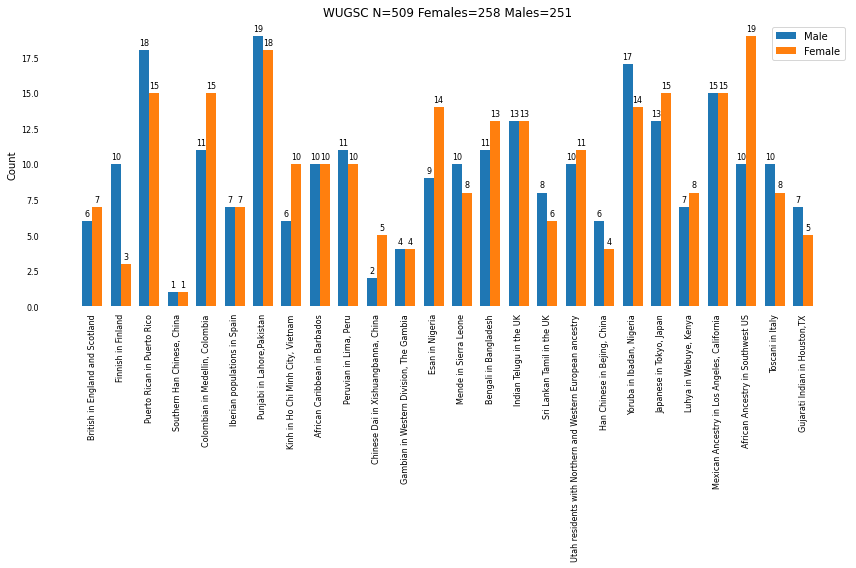

(552, 6)
(630, 6)


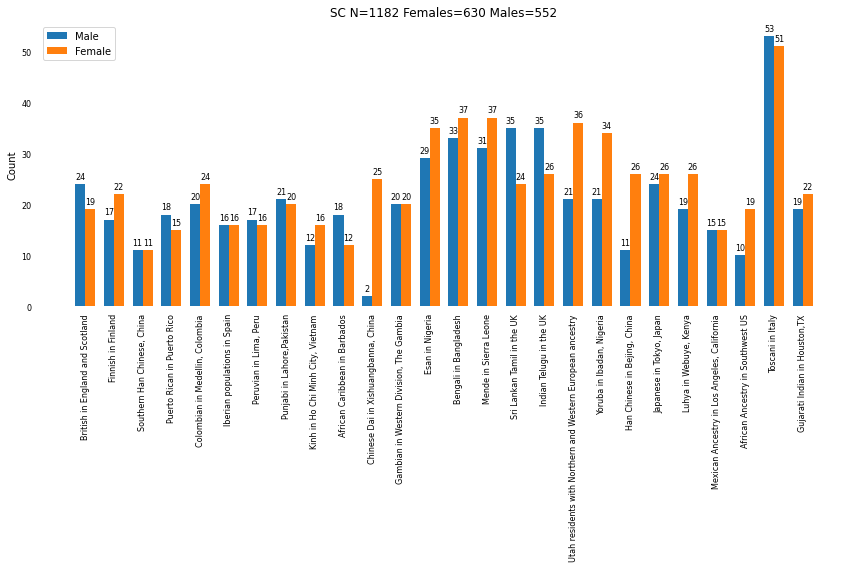

(449, 6)
(449, 6)


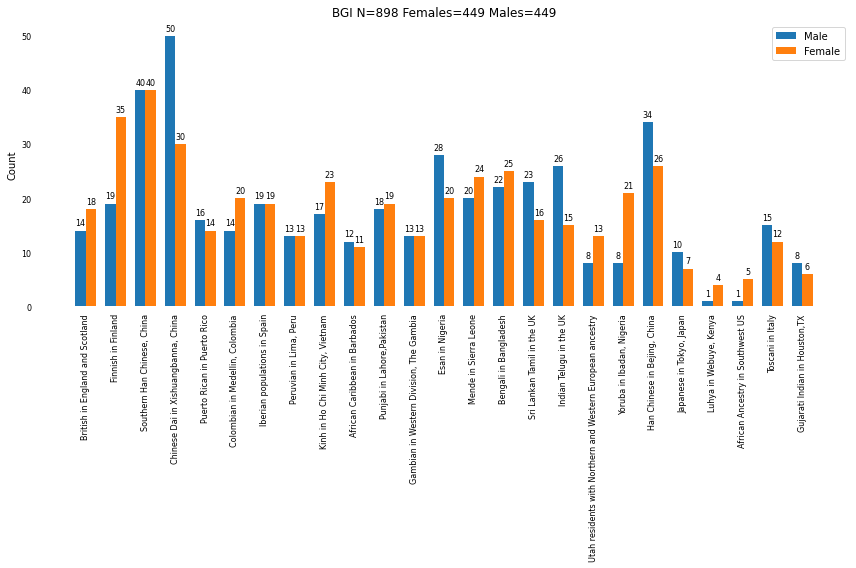

In [34]:
# What are the demographic stats for BI and WUGSC?
for center in ['BI','WUGSC','SC','BGI']:
    bi_df = dem_df[dem_df['centers'].str.contains(center)]
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    width = 0.35

    xy_df = bi_df[bi_df['Gender'] == 'male']
    xx_df = bi_df[bi_df['Gender'] == 'female']
    print(xy_df.shape)
    print(xx_df.shape)

    pop_labels = bi_df['Population Description'].unique()

    x_positions = np.arange(len(pop_labels))

    xy_counts = []
    xx_counts = []
    for pop in pop_labels:
        # count number of male and female in each
        xy_counts.append(xy_df[xy_df['Population Description'] == pop].shape[0])
        xx_counts.append(xx_df[xx_df['Population Description'] == pop].shape[0])

    rects1 = ax.bar(x_positions - width/2, xy_counts, width, label='Male')
    rects2 = ax.bar(x_positions + width/2, xx_counts, width, label='Female')

    ax.bar_label(rects1, padding=3,size=8)
    ax.bar_label(rects2, padding=3,size=8)
    clear_ax(ax)
    ax.set_ylabel('Count')
    
    ax.set_title('{} N={} Females={} Males={}'.format(center,
    str(len(bi_df['Sample'].unique())),
    str(xx_df.shape[0]),
    str(xy_df.shape[0]),
))

    ax.set_xticks(list(range(len(pop_labels))))
    ax.set_xticklabels(pop_labels,rotation=90)
    ax.legend()
    fig.tight_layout()
    plt.savefig('{}_center_1000_genomes_demographics.jpg'.format(center), dpi=300)
    plt.show()

In [43]:
samples_df = dem_df[dem_df['centers'].str.contains('BI')]

import random
random.seed(0)
# choose 7 male and female from each population (take the first 7), 
samples_to_keep = []
for pop in final_samples_df['Population Description'].unique():
    # SKIP "Chinese Dai in Xishuangbanna, China" since it has < 7
    if pop == "Chinese Dai in Xishuangbanna, China":
        continue
    print(pop)
    sub_samples_df = samples_df[samples_df['Population Description'] == pop]
    sub_samples_df_xy = sub_samples_df[sub_samples_df['Gender'] == 'male']
    sub_samples_df_xx = sub_samples_df[sub_samples_df['Gender'] == 'female']
    for i in range(7):
        samples_to_keep.append(list(sub_samples_df_xy['Sample'])[i])
        samples_to_keep.append(list(sub_samples_df_xx['Sample'])[i])

# 25 populations * 2 sexes * 7 individuals
assert(len(samples_to_keep) == 350)

# save the lists
with open('BI_350_1000_genomes_samples.txt','w') as outfile:
    for s in samples_to_keep:
        outfile.write(s + '\n')

keepers_df = samples_df[samples_df['Sample'].isin(samples_to_keep)]
keepers_df.to_csv('BI_350_1000_genomes_sample_information.tsv', sep='\t')

British in England and Scotland
Finnish in Finland
Southern Han Chinese, China
Puerto Rican in Puerto Rico
Colombian in Medellin, Colombia
Iberian populations in Spain
Kinh in Ho Chi Minh City, Vietnam
African Caribbean in Barbados
Peruvian in Lima, Peru
Gambian in Western Division, The Gambia
Punjabi in Lahore,Pakistan
Esan in Nigeria
Bengali in Bangladesh
Mende in Sierra Leone
Sri Lankan Tamil in the UK
Indian Telugu in the UK
Utah residents with Northern and Western European ancestry
Yoruba in Ibadan, Nigeria
Han Chinese in Bejing, China
Japanese in Tokyo, Japan
Luhya in Webuye, Kenya
African Ancestry in Southwest US
Mexican Ancestry in Los Angeles, California
Toscani in Italy
Gujarati Indian in Houston,TX
